In [1]:
from accelerate import Accelerator
import os 
import numpy as np
import torch
from models.mae_with_hemisphere_embed_and_diff_dim_per_area import MAE_with_region_stitcher
from utils.config_utils import config_from_kwargs, update_config
from utils.utils import set_seed, move_batch_to_device
from loader.data_loader_unbalanced_lump_short_list import *
from utils.mask import get_force_mask
from utils.metric_utils import Poisson_fraction_deviance_explained, get_deviance_explained

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
session_order_file="/work/hdd/bdye/jxia4/data/tables_and_infos/session_order.pkl"
session_order = pickle.load(open(session_order_file, 'rb'))
eids = [int(x) for x in np.sort(session_order[:40])]

In [3]:
include_opto = False
#with_reg = True

base_path = '/work/hdd/bdye/jxia4/results/mae_results'
num_train_sessions = len(eids)

mask_mode = 'region'
region_channel_num_encoder = 48 # number of region channels in encoder
unit_embed_dim = 50
n_layers = 5
consistency = True

num_epochs = 1000
batch_size = 16
use_wandb = False

kwargs = {
    "model": f"include:/work/hdd/bdye/jxia4/code/autoencoder_mae/src/configs/mae_with_hemisphere_embed_and_diff_dim_per_area.yaml",
}

config = config_from_kwargs(kwargs)
config = update_config("/work/hdd/bdye/jxia4/code/autoencoder_mae/src/configs/finetune_sessions_trainer.yaml", config)

config['model']['encoder']['masker']['mask_mode'] = mask_mode
config['model']['encoder']['stitcher']['n_channels_per_region'] = region_channel_num_encoder
config['model']['encoder']['stitcher']['unit_embed_dim'] = unit_embed_dim
config['training']['num_epochs'] = num_epochs
config['wandb']['use'] = use_wandb

meta_data = {}


dataloader, num_neurons, datasets, areaoi_ind, area_ind_list_list, heldout_info_list, trial_type_dict = make_loader(eids, batch_size, include_opto=include_opto)
set_seed(config.seed) 

meta_data['area_ind_list_list'] = area_ind_list_list
meta_data['areaoi_ind'] = areaoi_ind
meta_data['num_sessions'] = len(eids)
meta_data['eids'] = eids

#load pr_max_dict.pkl
pr_max_dict_path = '/work/hdd/bdye/jxia4/data/tables_and_infos/pr_max_dict.pkl'
with open(pr_max_dict_path, 'rb') as f:
    pr_max_dict = pickle.load(f)

for k, v in pr_max_dict.items():
    pr_max_dict[k] = int(v)

meta_data['pr_max_dict'] = pr_max_dict

trial_type_values = list(trial_type_dict.values())
meta_data['trial_type_values'] = trial_type_values

config = update_config(config, meta_data) # so that everything is saved in the config file
test_dataloader = dataloader['test']

accelerator = Accelerator()

model_path = f'{base_path}/train/svoboda_lump_short_list_wo_trial_type_embed/include_opto_{include_opto}/consistency_{consistency}/n_layers_{n_layers}/encoder_factors_{region_channel_num_encoder}/unit_embed_dim_{unit_embed_dim}/num_session_{num_train_sessions}/model_best.pt'
model = MAE_with_region_stitcher(config.model, **meta_data)

state_dict = torch.load(model_path)['model']
model.load_state_dict(state_dict)
model = accelerator.prepare(model)

model.eval()

0
1
3
4
5
8
9
12
16
17
19
23
24
25
27
28
29
30
31
32
33
34
37
39
40
42
44
80
84
105
107
109
128
146
161
163
168
169
171
172
num_neurons:  [289, 193, 278, 339, 281, 186, 96, 220, 182, 277, 239, 140, 351, 145, 425, 274, 269, 253, 251, 256, 212, 239, 173, 355, 345, 271, 271, 185, 96, 223, 169, 318, 352, 179, 231, 150, 97, 116, 313, 173]
num_trials:  {'train': [156, 202, 243, 262, 258, 258, 248, 240, 273, 180, 206, 264, 184, 288, 187, 219, 211, 297, 275, 309, 262, 291, 228, 276, 319, 222, 231, 177, 199, 219, 191, 198, 243, 186, 205, 199, 236, 198, 252, 169], 'val': [52, 67, 81, 88, 86, 86, 83, 80, 91, 60, 69, 88, 62, 96, 62, 73, 70, 99, 92, 103, 88, 97, 76, 92, 106, 74, 77, 59, 66, 73, 64, 66, 81, 62, 68, 67, 79, 66, 84, 56], 'test': [53, 68, 81, 88, 86, 86, 83, 80, 92, 61, 69, 89, 62, 96, 63, 74, 71, 100, 92, 104, 88, 98, 76, 93, 107, 74, 78, 60, 67, 73, 64, 67, 81, 63, 69, 67, 79, 66, 85, 57]}
Succesfully constructing the dataloader for  train
Succesfully constructing the dataloader for 

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/tmp/ipykernel_695073/3680164316.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of

MAE_with_region_stitcher(
  (encoder): NeuralEncoder(
    (stitchers): NeuralStitcher_cross_att(
      (unit_embed_dict): ModuleDict(
        (0): Embedding(289, 50)
        (1): Embedding(193, 50)
        (3): Embedding(278, 50)
        (4): Embedding(339, 50)
        (5): Embedding(281, 50)
        (8): Embedding(186, 50)
        (9): Embedding(96, 50)
        (12): Embedding(220, 50)
        (16): Embedding(182, 50)
        (17): Embedding(277, 50)
        (19): Embedding(239, 50)
        (23): Embedding(140, 50)
        (24): Embedding(351, 50)
        (25): Embedding(145, 50)
        (27): Embedding(425, 50)
        (28): Embedding(274, 50)
        (29): Embedding(269, 50)
        (30): Embedding(253, 50)
        (31): Embedding(251, 50)
        (32): Embedding(256, 50)
        (33): Embedding(212, 50)
        (34): Embedding(239, 50)
        (37): Embedding(173, 50)
        (39): Embedding(355, 50)
        (40): Embedding(345, 50)
        (42): Embedding(271, 50)
        (44): Em

In [4]:
test_dataloader = dataloader['test']

In [6]:
def get_y(trial_type, trial_type_dict, keys_left, keys_right, keys_ignore=None):
    y = np.ones_like(trial_type, dtype=int)*10

    for key in keys_left:
        y[trial_type == trial_type_dict[key]] = 0

    for key in keys_right:
        y[trial_type == trial_type_dict[key]] = 1

    if keys_ignore is not None:
        for key in keys_ignore:
            y[trial_type == trial_type_dict[key]] = 2
            
    return y

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import balanced_accuracy_score

In [ ]:
def decode_y(x, y):

    '''
    x: (B, n) input vector
    y: (B,) target vector, binary/multiclass labels
    
    B is number of samples, n is number of features

    return:
    y_pred: (B,) predicted target vector
    score: float, balanced accuracy score
    '''

    clf = LogisticRegression(penalty = 'l1', solver='liblinear', max_iter=20000, fit_intercept=True, tol = 1e-3)
    
    #compute weight for samples
    weight = compute_class_weight('balanced', classes=np.unique(y), y=y)

    weight_vec = np.zeros_like(y, dtype=float)
    for i, class_i in enumerate(np.unique(y)):
        weight_vec[y==class_i] = weight[i]

    #cross_validate
    n_trial_train = int(x.shape[0]*0.6)
    train_x = x[:n_trial_train]
    train_y = y[:n_trial_train]
    test_x = x[n_trial_train:]
    test_y = y[n_trial_train:]

    clf.fit(train_x, train_y, sample_weight=weight_vec[:n_trial_train])
    y_pred_test = clf.predict(test_x)

    #calculate balanced accuracy
    score = balanced_accuracy_score(test_y, y_pred_test)

    return y_pred_test, score, test_y

In [11]:
set_seed(config.seed)  

decode_score_dict = {'stim': {}, 'choice': {}}

with torch.no_grad():
    for batch in test_dataloader:
        device = accelerator.device
        batch = move_batch_to_device(batch, device)
        B = batch['spikes_data'].size(0)
        T = batch['spikes_data'].size(1)
        eid = batch['eid'][0].item()
        print('session id: ', eid)

        neuron_regions = batch['neuron_regions'][0] #(N,) area_ind_list
        trial_type = batch['trial_type'] # (B,) trial_type
        area_ind_unique_tensor = neuron_regions.unique()
        R = len(area_ind_unique_tensor) #number of regions

        #don't mask any data
        mask_T = torch.zeros([B,T], dtype=torch.bool, device=device)
        mask_R = torch.zeros([B,R], dtype=torch.bool, device=device)
        ids_restore_R = None
        ids_restore_T = None
        mask = torch.zeros([B,T,R], dtype=torch.bool, device=device)

        force_mask ={'mask': mask, 
                    'mask_R': mask_R, 
                    'mask_T': mask_T, 
                    'ids_restore_R': ids_restore_R, 
                    'ids_restore_T': ids_restore_T}

        area_ind_list_full = batch['neuron_regions_full'][0] # (N_all,) 

        x, mask, mask_R, mask_T, ids_restore_R, ids_restore_T = model.encoder(batch['spikes_data'], 
                                                                            batch['spikes_timestamps'],
                                                                            area_ind_unique_tensor, 
                                                                            batch['neuron_regions'],
                                                                            batch['is_left'],
                                                                            batch['trial_type'], 
                                                                            mask_mode, 
                                                                            batch['eid'][0], 
                                                                            force_mask)
        
        # Decode
        factors_pred_dict = {}
        for area_ind in areaoi_ind:
            x_tmp = x[:,:, areaoi_ind==area_ind,:].squeeze(dim=2) # (B, T, H)
            factors_pred_dict[str(area_ind)] = model.stitch_decoder.linear_layer_dict[str(area_ind)](x_tmp) # (B, T, n_channels_this_region)


        trial_type_np = trial_type.cpu().numpy()
        y_stim = get_y(trial_type_np, trial_type_dict, ['hit_left', 'miss_left', 'ignore_left'], ['hit_right', 'miss_right', 'ignore_right'])
        y_choice = get_y(trial_type_np, trial_type_dict, ['hit_left', 'miss_right'], ['hit_right', 'miss_left'], ['ignore_left', 'ignore_right'])

        if any(y_stim==10) or any(y_choice==10):
            print('wierd y_stim or y_choice')
            break
        
        decode_score_dict['stim'][str(eid)] = {'spike_data': {}, 'inferred_factors': {}}
        decode_score_dict['choice'][str(eid)] = {'spike_data': {}, 'inferred_factors': {}}

        for area_ind_i, area_ind in enumerate(areaoi_ind):
            #no mask MAE
            factors_region = factors_pred_dict[str(area_ind)]
            spikes_region = batch['spikes_data_full'][:,:,area_ind_list_full==area_ind]
            if spikes_region.size(2)<=5:
                continue

            #stimulus decode
            x_stim_spike_data = torch.sum(spikes_region[:, 105:115, :], dim=1).cpu().numpy() # (B, n_channels_this_region)
            x_stim_factors = torch.sum(factors_region[:, 105:115, :], dim=1).cpu().numpy() # (B, n_channels_this_region)

            #choice decode
            x_choice_spike_data = torch.sum(spikes_region[:, 225:235, :], dim=1).cpu().numpy() # (B, n_channels_this_region)
            x_choice_factors = torch.sum(factors_region[:, 225:235, :], dim=1).cpu().numpy() # (B, n_channels_this_region)


            #print('stim, data, decode: ')
            y_stim_pred_data, stim_score_data, y_stim_test = decode_y(x_stim_spike_data, y_stim)
            
            #print('stim, factors, decode: ')
            y_stim_pred_factors, stim_score_factors, junk = decode_y(x_stim_factors, y_stim)

            #print('choice, data, decode: ')
            y_choice_pred_data, choice_score_data, y_choice_test = decode_y(x_choice_spike_data, y_choice)

            #print('choice, factors, decode: ')
            y_choice_pred_factors, choice_score_factors, junk = decode_y(x_choice_factors, y_choice)

            decode_score_dict['stim'][str(eid)]['spike_data'][str(area_ind)] = stim_score_data
            decode_score_dict['stim'][str(eid)]['inferred_factors'][str(area_ind)] = stim_score_factors

            decode_score_dict['choice'][str(eid)]['spike_data'][str(area_ind)] = choice_score_data
            decode_score_dict['choice'][str(eid)]['inferred_factors'][str(area_ind)] = choice_score_factors
            

seed set to 42
session id:  32
session id:  29
session id:  28
session id:  44
session id:  5
session id:  24


/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pre

session id:  169
session id:  80
session id:  172
session id:  9
session id:  42
session id:  17
session id:  25
session id:  109
session id:  161
session id:  16
session id:  30
session id:  40
session id:  0
session id:  146
session id:  8


/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pre

session id:  23
session id:  1
session id:  105
session id:  34
session id:  3
session id:  107
session id:  168
session id:  4
session id:  163
session id:  39
session id:  128
session id:  19
session id:  37
session id:  31
session id:  33


/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pre

session id:  12
session id:  27
session id:  84
session id:  171


In [8]:
path = '/work/hdd/bdye/jxia4/data/tables_and_infos/'

#load region_info_summary.pkl
with open(path + 'region_info_summary.pkl', 'rb') as f:
    [brain_region_list, session_by_region, session_by_region_n, junk] = pickle.load(f)

brain_region_list = np.append(brain_region_list, 'ALM') #add ALM to the list

brain_region_list_acronym = brain_region_list.copy()
brain_region_list_acronym[brain_region_list_acronym == 'Midbrain reticular nucleus'] = 'MRN'
brain_region_list_acronym[brain_region_list_acronym == 'Ventral anterior-lateral complex of the thalamus'] = 'VAL-VM'
brain_region_list_acronym[brain_region_list_acronym == 'Orbital area, lateral part, layer 1'] = 'lOrb'
brain_region_list_acronym[brain_region_list_acronym == 'Orbital area, ventrolateral part, layer 1'] = 'vlOrb'
brain_region_list_acronym[brain_region_list_acronym == 'Superior colliculus, motor related, deep gray layer'] = 'SC'

In [13]:
#for all held-out areas, plot decode_score for stim, data vs factors

decode_score_dict_reorg = {'stim': {}, 'choice': {}}

for heldout_info in heldout_info_list:
    area_ind = heldout_info['heldout_region_ind']
    eid = heldout_info['session_ind']

    if str(area_ind) not in decode_score_dict_reorg['stim']:
        decode_score_dict_reorg['stim'][str(area_ind)] = {'spike_data': [], 'inferred_factors': [], 'eid_list': []}
        decode_score_dict_reorg['choice'][str(area_ind)] = {'spike_data': [], 'inferred_factors': [], 'eid_list': []}

    for var_name in ['stim', 'choice']:

        if str(area_ind) not in decode_score_dict[var_name][str(eid)]['spike_data']:
            print(f"Warning: {var_name} data for area {area_ind} and session {eid} not found in decode_score_dict.")
            continue
        score_data_tmp = decode_score_dict[var_name][str(eid)]['spike_data'][str(area_ind)]
        score_factors_tmp = decode_score_dict[var_name][str(eid)]['inferred_factors'][str(area_ind)]
        
        decode_score_dict_reorg[var_name][str(area_ind)]['spike_data'].append(score_data_tmp)
        decode_score_dict_reorg[var_name][str(area_ind)]['inferred_factors'].append(score_factors_tmp)
        decode_score_dict_reorg[var_name][str(area_ind)]['eid_list'].append(eid)

         


ALM
spike data score: 0.6 0.12
factors score: 0.71 0.08
lOrb
spike data score: 0.58 0.08
factors score: 0.5 0.13
vlOrb
spike data score: 0.53 0.08
factors score: 0.61 0.13
Pallidum
spike data score: 0.65 0.07
factors score: 0.8 0.13
Striatum
spike data score: 0.53 0.04
factors score: 0.73 0.06
MRN
spike data score: 0.62 0.08
factors score: 0.68 0.12
SC
spike data score: 0.66 0.08
factors score: 0.76 0.09


Text(0.5, 1.0, 'Stim Decoding Score by Held-out Area')

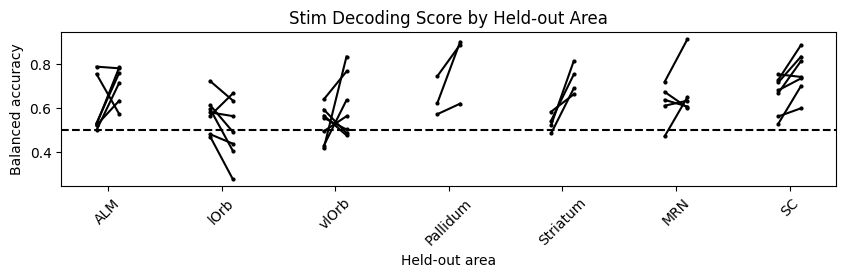

In [22]:
# plot decode_score for stim, data vs factors separately for each held-out area
var_name = 'stim' # or 'choice'

plt.figure(figsize=(10, 2))
i = 1
xticks = []
xticks_labels = []
for area_ind in areaoi_ind:
    if str(area_ind) not in decode_score_dict_reorg[var_name]:
        continue

    score_data = decode_score_dict_reorg[var_name][str(area_ind)]['spike_data']
    score_factors = decode_score_dict_reorg[var_name][str(area_ind)]['inferred_factors']
    
    x_coords = np.zeros((len(score_data), 2))
    x_coords[:,0] = i-0.1
    x_coords[:,1] = i+0.1

    y_coords = np.stack((score_data, score_factors), axis=1)

    plt.plot(x_coords.T, y_coords.T, marker='o', markersize=2, color='k')

    print(brain_region_list_acronym[area_ind])
    print('spike data score:', np.around(np.mean(score_data),2), np.around(np.std(score_data),2))
    print('factors score:', np.around(np.mean(score_factors),2), np.around(np.std(score_factors),2))

    xticks.append(i)
    xticks_labels.append(brain_region_list_acronym[area_ind])

    i += 1
    #break

plt.xticks(xticks, xticks_labels, rotation=45)
plt.xlabel('Held-out area')
plt.ylabel('Balanced accuracy')

plt.axhline(1/2, color='k', linestyle='--', label='Chance level')

plt.title(f'{var_name.capitalize()} Decoding Score by Held-out Area')

## Calculate intrinsic dimensionality of the predicted firing rates for each brain area based on latent factors

In [17]:
set_seed(config.seed)  

intrinsic_dim_dict = {}


with torch.no_grad():
    for batch in test_dataloader:
        device = accelerator.device
        batch = move_batch_to_device(batch, device)
        B = batch['spikes_data'].size(0)
        T = batch['spikes_data'].size(1)
        eid = batch['eid'][0].item()
        print('session id: ', eid)

        neuron_regions = batch['neuron_regions'][0] #(N,) area_ind_list
        trial_type = batch['trial_type'] # (B,) trial_type
        area_ind_unique_tensor = neuron_regions.unique()
        R = len(area_ind_unique_tensor) #number of regions

        #don't mask any data
        mask_T = torch.zeros([B,T], dtype=torch.bool, device=device)
        mask_R = torch.zeros([B,R], dtype=torch.bool, device=device)
        ids_restore_R = None
        ids_restore_T = None
        mask = torch.zeros([B,T,R], dtype=torch.bool, device=device)

        force_mask ={'mask': mask, 
                    'mask_R': mask_R, 
                    'mask_T': mask_T, 
                    'ids_restore_R': ids_restore_R, 
                    'ids_restore_T': ids_restore_T}

        area_ind_list_full = batch['neuron_regions_full'][0] # (N_all,) 

        x, mask, mask_R, mask_T, ids_restore_R, ids_restore_T = model.encoder(batch['spikes_data'], 
                                                                            batch['spikes_timestamps'],
                                                                            area_ind_unique_tensor, 
                                                                            batch['neuron_regions'],
                                                                            batch['is_left'],
                                                                            batch['trial_type'], 
                                                                            mask_mode, 
                                                                            batch['eid'][0], 
                                                                            force_mask)
        
        intrinsic_dim_dict[str(eid)] = {}
        
        # Decode
        factors_pred_dict = {}
        for area_ind in areaoi_ind:
            x_tmp = x[:,:, areaoi_ind==area_ind,:].squeeze(dim=2) # (B, T, H)
            factors_pred_dict[str(area_ind)] = model.stitch_decoder.linear_layer_dict[str(area_ind)](x_tmp) # (B, T, n_channels_this_region)
        
            #calculate intrinsic dimension using participation ratio
            factors_in_area = factors_pred_dict[str(area_ind)]

            if str(area_ind) not in model.stitch_decoder.stitch_decoder_dict[str(eid)]:
                #print(f"Warning: Stitch decoder for area {area_ind} not found in model.")
                continue
            
            log_fr = model.stitch_decoder.stitch_decoder_dict[str(eid)][str(area_ind)](factors_in_area) #(B, T, N_this_region)

            fr = torch.exp(log_fr) 

            N_region = fr.size(-1)
            fr = fr.reshape(-1, N_region)

            centered_fr = fr - fr.mean(dim=0, keepdim=True)
            u, s, v = torch.svd(centered_fr)
            s_squared = s ** 2
            participation_ratio = (torch.sum(s_squared)**2) / torch.sum(s_squared**2)

            intrinsic_dim_dict[str(eid)][str(area_ind)] = participation_ratio.item()


seed set to 42
session id:  32
session id:  29
session id:  28
session id:  44
session id:  5
session id:  24
session id:  169
session id:  80
session id:  172
session id:  9
session id:  42
session id:  17
session id:  25
session id:  109
session id:  161
session id:  16
session id:  30
session id:  40
session id:  0
session id:  146
session id:  8
session id:  23
session id:  1
session id:  105
session id:  34
session id:  3
session id:  107
session id:  168
session id:  4
session id:  163
session id:  39
session id:  128
session id:  19
session id:  37
session id:  31
session id:  33
session id:  12
session id:  27
session id:  84
session id:  171


In [18]:
intrinsic_dim_dict_reorg = {}


for area_ind in areaoi_ind:

    if str(area_ind) not in intrinsic_dim_dict_reorg:
        intrinsic_dim_dict_reorg[str(area_ind)] = []

    for eid in eids:
        if str(area_ind) not in intrinsic_dim_dict[str(eid)]:
            #print(f"Warning: area {area_ind} and session {eid} not found in intrinsic_dim_dict.")
            continue
        
        intrinsic_dim_dict_reorg[str(area_ind)].append(intrinsic_dim_dict[str(eid)][str(area_ind)])


In [19]:
for area_ind in areaoi_ind:
    if str(area_ind) not in intrinsic_dim_dict_reorg:
        continue

    intrinsic_dim_values = intrinsic_dim_dict_reorg[str(area_ind)]
    
    print(f'Area {brain_region_list_acronym[area_ind]}: intrinsic dimension = {np.mean(intrinsic_dim_values):.2f} ± {np.std(intrinsic_dim_values):.2f}')

Area ALM: intrinsic dimension = 4.71 ± 1.45
Area lOrb: intrinsic dimension = 4.82 ± 1.40
Area vlOrb: intrinsic dimension = 4.21 ± 1.43
Area Pallidum: intrinsic dimension = 3.51 ± 1.36
Area Striatum: intrinsic dimension = 4.19 ± 1.53
Area VAL-VM: intrinsic dimension = 5.63 ± 1.40
Area MRN: intrinsic dimension = 3.90 ± 0.98
Area SC: intrinsic dimension = 4.50 ± 1.05
